In [5]:

import numpy as np
import matplotlib.pyplot as plt



In [13]:
# functions for processing geos data
# 500 m resolution full-disk data of FY4A(104.7E, .hdf), FY4B(105E, .hdf) and GK2A(128.2E, .nc)
import numpy as np
import xarray as xr
import h5py
from osgeo import gdal
from scipy.interpolate import griddata

def load_geos(sensor, file, xmin, xmax, ymin, ymax):
	"""
	load data and return the radiance
	Input:
		sensor: 'FY4A', 'FY4B' or 'GK2A'
		file:    the file path of the geos image
		xmin: index of left lontitude
		xmax: index of right lontitude
		ymin: index of top latitude
		ymax: index of bottom latitude
	Output:
		radiance: radiance of the geos image	
    """
	if sensor == 'GK2A':
		# the calibration file is needed
		cal = np.loadtxt("E:/DataProcess/GK2A/VI006_con_abl.txt")
		ds = xr.open_dataset(file)
		dn = ds['image_pixel_values'].values[ymin:ymax, xmin:xmax]
		radiance = cal[dn, 1]
	elif sensor == 'FY4A':
		ds = h5py.File(file, 'r+')
		dn = ds['NOMChannel02'][ymin:ymax, xmin:xmax]
		cal = ds['CALChannel02'][:]
		radiance = cal[dn]
	elif sensor == 'FY4B':
		ds = h5py.File(file, 'r+')
		dn = ds['Data/NOMChannel02'][ymin:ymax, xmin:xmax]
		cal = ds['Calibration/CALChannel02'][:]
		radiance = cal[dn]
	return radiance
    
def lincol2lonlat(sensor, Line, Column):
	"""
	(Line, Column)	->  (Latitude, Longitude)
	Input:
		sensor:    'FY4A', 'FY4B' or 'GK2A'
		Line:      line index of geos image
		Column:    column index of geos image
	Output:
		Latitude:  latitude of geos image
		Longitude: longitude of geos image	
    """
	degtorad=3.14159265358979 / 180.0
	if (sensor == 'GK2A'):
		COFF=11000.5
		CFAC=8.170135561335742e7
		LOFF=11000.5
		LFAC=8.170135561335742e7
		sub_lon=128.2
	elif (sensor == 'FY4A'):
		COFF=10991.5 
		CFAC=81865099
		LOFF=10991.5 
		LFAC=81865099
		sub_lon=104.7
	elif (sensor == 'FY4B'):
		COFF=10991.5 
		CFAC=81865099
		LOFF=10991.5 
		LFAC=81865099
		sub_lon=105.0	
	sub_lon=sub_lon*degtorad
	x= degtorad *( (Column - COFF)*2**16 / CFAC )
	y= degtorad *( (Line - LOFF)*2**16 / LFAC )
	Sd = np.sqrt( (42164.0*np.cos(x)*np.cos(y))**2 - (np.cos(y)**2 + 1.006739501*np.sin(y)**2)*1737122264)
	Sn = (42164.0*np.cos(x)*np.cos(y)-Sd) / (np.cos(y)**2 + 1.006739501*np.sin(y)**2)
	S1 = 42164.0 - ( Sn * np.cos(x) * np.cos(y) )
	S2 = Sn * ( np.sin(x) * np.cos(y) )
	S3 = -Sn * np.sin(y)
	Sxy = np.sqrt( ((S1*S1)+(S2*S2)) )
	nlon = (np.arctan(S2/S1)+sub_lon)/degtorad 
	nlat = np.arctan( ( 1.006739501 *S3)/Sxy)/degtorad 
	return (nlat, nlon)

def lonlat2lincol(sensor, lat, lon):
	"""
	(Latitude, Longitude)	->  (Line, Column)
	Input:
		sensor:    'FY4A', 'FY4B' or 'GK2A'
		Latitude:  latitude of geos image
		Longitude: longitude of geos image	
	Output:
		Line:      line index of geos image
		Column:    column index of geos image
    """
	degtorad=3.14159265358979 / 180.0
	if (sensor == 'GK2A'):
		COFF=11000.5
		CFAC=8.170135561335742e7
		LOFF=11000.5
		LFAC=8.170135561335742e7
		sub_lon=128.2
	elif (sensor == 'FY4A'):
		COFF=10991.5 
		CFAC=81865099
		LOFF=10991.5 
		LFAC=81865099
		sub_lon=104.7
	elif (sensor == 'FY4B'):
		COFF=10991.5 
		CFAC=81865099
		LOFF=10991.5 
		LFAC=81865099
		sub_lon=105.0	
	sub_lon=sub_lon*degtorad
	Latitude=lat*degtorad
	Longitude=lon*degtorad
	c_lat = np.arctan(0.993305616*np.tan(Latitude))
	RL =  6356.7523 / np.sqrt( 1.0 - 0.00669438444*np.cos(c_lat)**2.0 )
	R1 =  42164.0 - RL *np.cos(c_lat)*np.cos(Longitude - sub_lon)
	R2 = -RL* np.cos(c_lat) *np.sin(Longitude - sub_lon)
	R3 =  RL* np.sin(c_lat)
	Rn =  np.sqrt(R1**2.0 + R2**2.0 + R3**2.0 )
	x = np.arctan(-R2 / R1) / degtorad
	y = np.arcsin(-R3 / Rn) / degtorad
	ncol=COFF + (x* 2.0**(-16) * CFAC)
	nlin=LOFF + (y* 2.0**(-16) * LFAC)
	return (nlin,ncol)

def subset_boundary(sensor, latmin, latmax, lonmin, lonmax):
	"""
	subset full-disk geos image by defined boundary
	Input:
		sensor:     'FY4A', 'FY4B' or 'GK2A'
		latmin:     bottom latitude
		latmax:     top latitude
		lonmin: 	left lontitude
		lonmax: 	right lontitude
	Output:
		Lin_top: 	top line index of subset area
		Lin_bottom: bottom line index of subset area
		Col_left: 	left column index of subset area
		Col_right: 	right column index of subset area
    """
	if (sensor == 'FY4A'):
		(Lin1,Col1) = lonlat2lincol(sensor, latmax, lonmin)
		(Lin2,Col2) = lonlat2lincol(sensor, latmin, lonmax)
	elif (sensor == 'GK2A'):
		(Lin1,Col1) = lonlat2lincol(sensor, latmax, lonmin)
		(Lin2,Col2) = lonlat2lincol(sensor, latmin, lonmax)
	elif (sensor == 'FY4B'):
		(Lin1,Col1) = lonlat2lincol(sensor, latmax, lonmin)
		(Lin2,Col2) = lonlat2lincol(sensor, latmin, lonmax)
	Col_left=int(np.floor(Col1))
	Lin_top=int(np.floor(Lin1))
	Col_right=int(np.ceil(Col2))
	Lin_bottom=int(np.ceil(Lin2))
    # (ymin, ymax, xmin, xmax)
	return (Lin_top, Lin_bottom, Col_left, Col_right)
          
def glt_warp(original_dataset, original_lon, original_lat, out_res, method='nearest'):
    """
    Geographic correction using geographic look-up table (GLT)
	Input:
    	original_dataset: original remote sensing image, 2D array
    	original_lon:     original longitude, 2D array
    	original_lat:  	  original latitude, 2D array
    	out_res:          spatial resolution of output image, unit: degree
    	method:           interpolation method, default is nearest (optional: 'nearest', 'linear', 'cubic')
    Output:
	  	interp_dataset:	  geographic corrected image, 2D array
    """
	# create grid
    lon_min, lon_max = np.nanmin(original_lon), np.nanmax(original_lon)
    lat_min, lat_max = np.nanmin(original_lat), np.nanmax(original_lat)
    grid_lon, grid_lat = np.meshgrid(
        np.arange(lon_min, lon_max, out_res),
        np.arange(lat_max, lat_min, -out_res),)
    # interpolate
    interp_dataset = griddata(
        (original_lon.ravel(), original_lat.ravel()), 
        original_dataset.ravel(),  
        (grid_lon, grid_lat),  
        method=method,  
        fill_value=np.nan,)
    return interp_dataset

def write_tiff(out_path, dataset, transform, nodata=np.nan):
    """
    save data as tiff file
	Input:
		out_path:  output file path
		dataset:   data to be saved
		transform: coordinate transformation information 
					(format: [upper-left longitude, longitude resolution, rotation angle,
					          upper-left latitude,  rotation angle,       latitude resolution])
		nodata:    invalid value
    """
    # build tiff file	
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(out_path, dataset[0].shape[1], dataset[0].shape[0], len(dataset), gdal.GDT_Float32)
    # set coordinate transformation information
    out_ds.SetGeoTransform(transform)
    out_ds.SetProjection('WGS84')
    # write dataset
    for i in range(len(dataset)):
        out_ds.GetRasterBand(i + 1).WriteArray(dataset[i])
        out_ds.GetRasterBand(i + 1).SetNoDataValue(nodata)
    out_ds.FlushCache()

In [12]:
# test GK2A

lonmin, lonmax = 116, 124
latmin, latmax = 4, 12

sensor = 'GK2A'

ymin, ymax, xmin, xmax = subset_boundary(sensor, latmin, latmax, lonmin, lonmax)

file = "data/gk2a_ami_le1b_vi006_fd005ge_202204170500.nc"

data = load_geos(sensor, file, xmin, xmax, ymin, ymax)

xgrid, ygrid = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin, ymax))
lat, lon = lincol2lonlat(sensor, ygrid, xgrid)

out_res = 500/111000
rs = glt_warp(data, lon, lat, out_res, method='linear')
transform = (np.nanmin(lon), out_res, 0, np.nanmax(lat), 0, -out_res)
write_tiff("output_GK2A.tiff", [rs], transform)



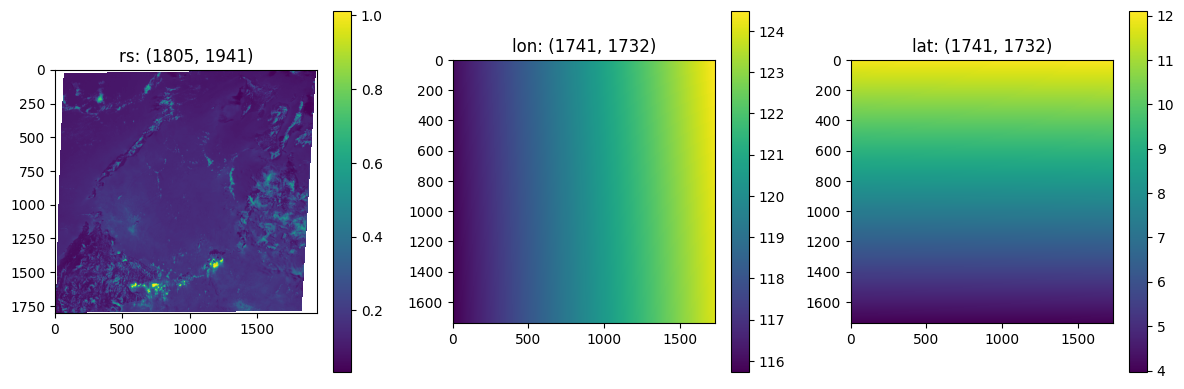

In [8]:
# test FY4A
file = "data/FY4A-_AGRI--_N_DISK_1047E_L1-_FDI-_MULT_NOM_20220417024500_20220417025959_0500M_V0001.hdf"

lonmin, lonmax = 116, 124
latmin, latmax = 4, 12

sensor = 'FY4A'

ymin, ymax, xmin, xmax = subset_boundary(sensor, latmin, latmax, lonmin, lonmax)

data = load_geos(sensor, file, xmin, xmax, ymin, ymax)

xgrid, ygrid = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin, ymax))
lat, lon = lincol2lonlat(sensor, ygrid, xgrid)

out_res = 500/111000
rs = glt_warp(data, lon, lat, out_res, method='linear')
transform = (np.nanmin(lon), out_res, 0, np.nanmax(lat), 0, -out_res)
write_tiff("output_FY4A.tif", [rs], transform)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(rs)
plt.colorbar()
plt.title(f"rs: {np.shape(rs)}")
plt.subplot(132)
plt.imshow(lon)
plt.colorbar()
plt.title(f"lon: {np.shape(lon)}")
plt.subplot(133)
plt.imshow(lat)
plt.colorbar()
plt.title(f"lat: {np.shape(lat)}")
plt.tight_layout()


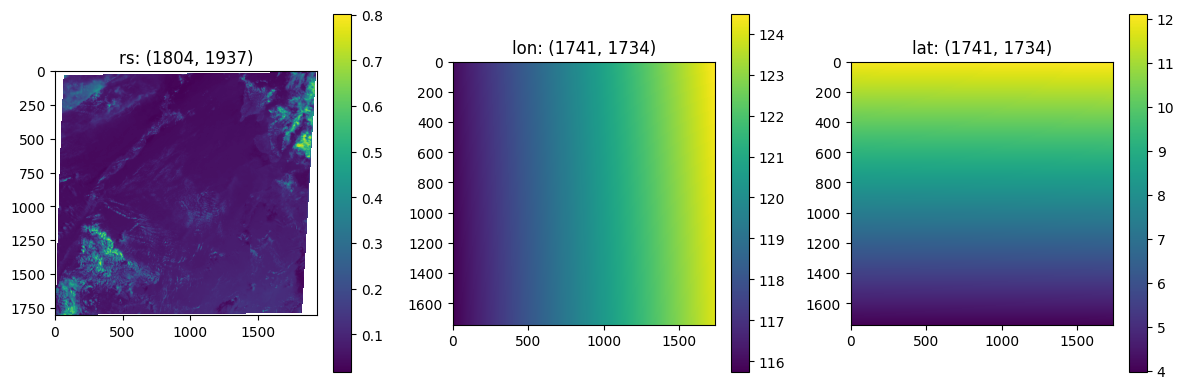

In [9]:
# test FY4B
file = "data/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20240312021500_20240312022959_0500M_V0001.HDF"

lonmin, lonmax = 116, 124
latmin, latmax = 4, 12

sensor = 'FY4B'

ymin, ymax, xmin, xmax = subset_boundary(sensor, latmin, latmax, lonmin, lonmax)

data = load_geos(sensor, file, xmin, xmax, ymin, ymax)

xgrid, ygrid = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin, ymax))
lat, lon = lincol2lonlat(sensor, ygrid, xgrid)

out_res = 500/111000
rs = glt_warp(data, lon, lat, out_res, method='linear')
transform = (np.nanmin(lon), out_res, 0, np.nanmax(lat), 0, -out_res)
write_tiff("output_FY4B.tif", [rs], transform)

